## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
core_used = 24
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [4]:
dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
drug_code = 'gdsc-1-FGFR_0939'
match_rules_data_code = 'fgfr4_model_ccle_match_rules'
folder_name = "FGFR4-combined-model-training"
exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [5]:
# dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
# drug_code = 'gdsc-2-Palbociclib'
# match_rules_data_code = 'cdk_model_match_rules'
# folder_name = "CDK46-combined-model-training"
# exp_id = "cdk46_v4" # experiment id, fgfr4_v1, cdk46_v1

In [6]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0 Feature Shape (665, 260) Label Shape (665,)
Data loaded for code ccle-gdsc-1-FGFR_0939-LN_IC50 Feature Shape (667, 19221) Label Shape (667,)


In [7]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [9]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(665, 19221)
(665,)


In [10]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [11]:
combined_feature_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,amTORC2_auc,amTORC2_median,amTORC2_tfc,amTORC2_tmax,amTORC2_max,amTORC2_tmin,amTORC2_min,amTORC2_ttsv,amTORC2_tsv,amTORC2_init
SIDM01132,3.955127,1.416840,6.620293,2.000000,3.333424,0.014355,5.654779,0.028569,2.726831,4.061776,...,0.001622,0.001435,1.732396,0.96,0.003096,0.0,0.001133,0.04,0.001133,0.001133
SIDM00848,4.247928,0.000000,6.174127,2.316146,3.823749,0.189034,1.321928,3.536053,3.943921,4.468583,...,0.463970,0.483035,0.281069,0.96,0.544116,0.0,0.424736,0.04,0.424736,0.424736
SIDM01111,4.327687,0.070389,5.979111,2.906891,4.904484,0.263034,2.235727,0.422233,4.432959,5.139961,...,0.073737,0.076469,0.295231,0.96,0.088013,0.0,0.067951,0.04,0.067951,0.067951
SIDM00909,3.264536,0.000000,6.096557,2.518535,3.040892,0.000000,0.831877,6.575615,4.656496,4.738768,...,0.042001,0.043628,0.375213,0.96,0.051130,0.0,0.037180,0.04,0.037180,0.037180
SIDM00807,5.128871,0.000000,6.691534,2.010780,4.976364,0.163499,1.636915,6.193575,3.505891,3.709291,...,0.153621,0.159928,0.308393,0.96,0.181684,0.0,0.138860,0.04,0.138860,0.138860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00217,4.489286,0.475085,6.759955,2.451541,3.305971,1.464668,0.056584,5.996615,5.134221,4.635754,...,0.015140,0.015568,0.485826,0.96,0.019511,0.0,0.013131,0.04,0.013131,0.013131
SIDM00214,4.628190,0.298658,5.996615,4.042644,4.784504,0.042644,1.761285,5.067811,5.783457,4.943453,...,0.001227,0.001096,2.566311,0.96,0.002511,0.0,0.000704,0.04,0.000704,0.000704
SIDM00194,4.229588,0.014355,6.664767,2.691534,3.454176,0.042644,0.739848,6.417009,4.442943,2.959770,...,0.059500,0.061853,0.369219,0.96,0.072176,0.0,0.052713,0.04,0.052713,0.052713
SIDM00193,3.477677,0.000000,6.385949,3.570463,3.232661,0.000000,0.275007,6.417515,6.407013,3.727920,...,0.046056,0.047720,0.353875,0.96,0.056037,0.0,0.041390,0.04,0.041390,0.041390


In [12]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

#### custom pipelines

In [13]:
def pipeline_select_genes_only(X_train, y_train, rng, model_used, keep_features, normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    dynamic_X_train = X_train[final_selected_features]
    static_X_train = X_train.drop(final_selected_features, axis=1)
    k = X_train.shape[1]
    if k > 500:
        k = 500  # limit the number of features to 500
    selected_features, scores = f_regression_select(static_X_train, y_train, k)
    for f in selected_features:
        final_selected_features.append(f)
    selected_X_train = X_train[final_selected_features]
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [14]:
def pipeline_select_only(X_train, y_train, rng, model_used, 
                                     keep_features, limit_features = False, 
                         normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    selected_X_train = X_train[final_selected_features]
    # get the scores for the selected features using f_regression
    k = selected_X_train.shape[1]
    if limit_features:
        if k > 500:
            k = 500  # limit the number of features to 500
    _, scores = f_regression_select(selected_X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [15]:
transformed_gene_list = [] 
# we deduce these from the original match rules file

gene_match_rules = match_rules.dropna(subset=['reference'])
for index, row in gene_match_rules.iterrows():
    gene = row['reference'].split(';')
    for g in gene:
        if g not in transformed_gene_list:
            transformed_gene_list.append(g)    
            
dynamic_features = list(dynamic_feature_data.columns)
transformed_dynamic_features = []
for f in dynamic_features:
    transformed_dynamic_features.append(f)
for g in transformed_gene_list:
    if g not in transformed_dynamic_features:
        transformed_dynamic_features.append(g)
        
print(f'Length of transformed gene features: {len(transformed_gene_list)}')
print(f'Length of transformed dynamic features: {len(transformed_dynamic_features)}')

Length of transformed gene features: 38
Length of transformed dynamic features: 298


## Analysis

### Initialisation

In [16]:
import pickle
experiments = ['control_dynamic',
               'specie_genes', 'specie_genes_dynamic',
               'select_gene_dynamic', 'combined']

model_used = "RandomForestRegressor"

df_list_total = []
for exp in experiments:
    df_list = []
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
    print(f'Loaded {model_used} for {exp}')
    df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
# total_df

Loaded RandomForestRegressor for control_dynamic
Loaded RandomForestRegressor for specie_genes
Loaded RandomForestRegressor for specie_genes_dynamic
Loaded RandomForestRegressor for select_gene_dynamic
Loaded RandomForestRegressor for combined


In [17]:
# for each model, create a dataframe with the feature importance of all features 

all_new_feat_imp = []
for index, row in total_df.iterrows():
    model = row['model']
    # print(model, row['condition'], row['rng'], row['experiment'])
    importances = model.feature_importances_.tolist()
    feature_names = row['feature_importance'][0]
    # make index a repeat of index over the number of features
    feat_imp = (feature_names, importances)
    all_new_feat_imp.append(feat_imp)
    
total_df.insert(4, 'tree_feature_importance', all_new_feat_imp)
    

### Specific Loading

In [46]:
powerkit = Powerkit(new_feature_data, new_label_data)
exp_condition = 'select_gene_dynamic'
# rename the 'experiment' column to 'condition' and 'condition' to 'model_name' 
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df, 
                                                   exp_condition, 
                                                   'tree_feature_importance', 
                                                   strict_mean=0.75)
mean_variation = get_variation(total_df, exp_condition, 
                               col_name='tree_feature_importance', 
                               use_iqr=False)

In [47]:
mean_contribution.shape

(623, 3)

In [48]:
mean_variation.shape

(623, 4)

In [49]:
# join the two dataframes
mean_df = mean_contribution.join(mean_variation, rsuffix='_variation')

In [50]:
mean_df.head(10)

,iteration_no,scores,count,variability_score,std,mean,count_variation
feature_names,,,,,,,
FURIN,51.294118,0.023885,85,0.594396,0.014197,0.023885,85
KLB,48.925532,0.020291,94,0.544901,0.011057,0.020291,94
SLC26A4,48.657895,0.014763,76,0.265641,0.003922,0.014763,76
THPO,49.032258,0.013282,93,0.425941,0.005657,0.013282,93
CCNI2,49.500000,0.013232,100,0.463006,0.006127,0.013232,100
GDF7,49.505263,0.012479,95,0.452186,0.005643,0.012479,95
ALB,49.909091,0.012204,99,0.570411,0.006961,0.012204,99
GLI3,49.500000,0.009968,100,0.520511,0.005188,0.009968,100
CATSPERG,49.918367,0.008492,98,0.569096,0.004833,0.008492,98


In [51]:
import seaborn as sns
condition_df = total_df[total_df['condition'] == exp_condition]
data = condition_df['tree_feature_importance']

# extract the feature names and scores from the feature importance column
feature_names = []
scores = []

for row in data:
    feature_names.append(row[0])
    scores.append(row[1])

print(len(feature_names), len(scores))

feature_names_all = []
scores_all = []

for feature_name, score in zip(feature_names, scores):
    for feature, score in zip(feature_name, score):
        feature_names_all.append(feature)
        scores_all.append(score)

print(len(feature_names_all), len(scores_all))

# create a dataframe from the feature names and scores
df = pd.DataFrame({'feature_names': feature_names_all, 'scores': scores_all})

df.head()


100 100
76000 76000


,feature_names,scores
0,pIGFR_auc,0.000460
1,pIGFR_median,0.000509
2,pIGFR_tfc,0.000727
3,pIGFR_tmax,0.000000
4,pIGFR_max,0.000548


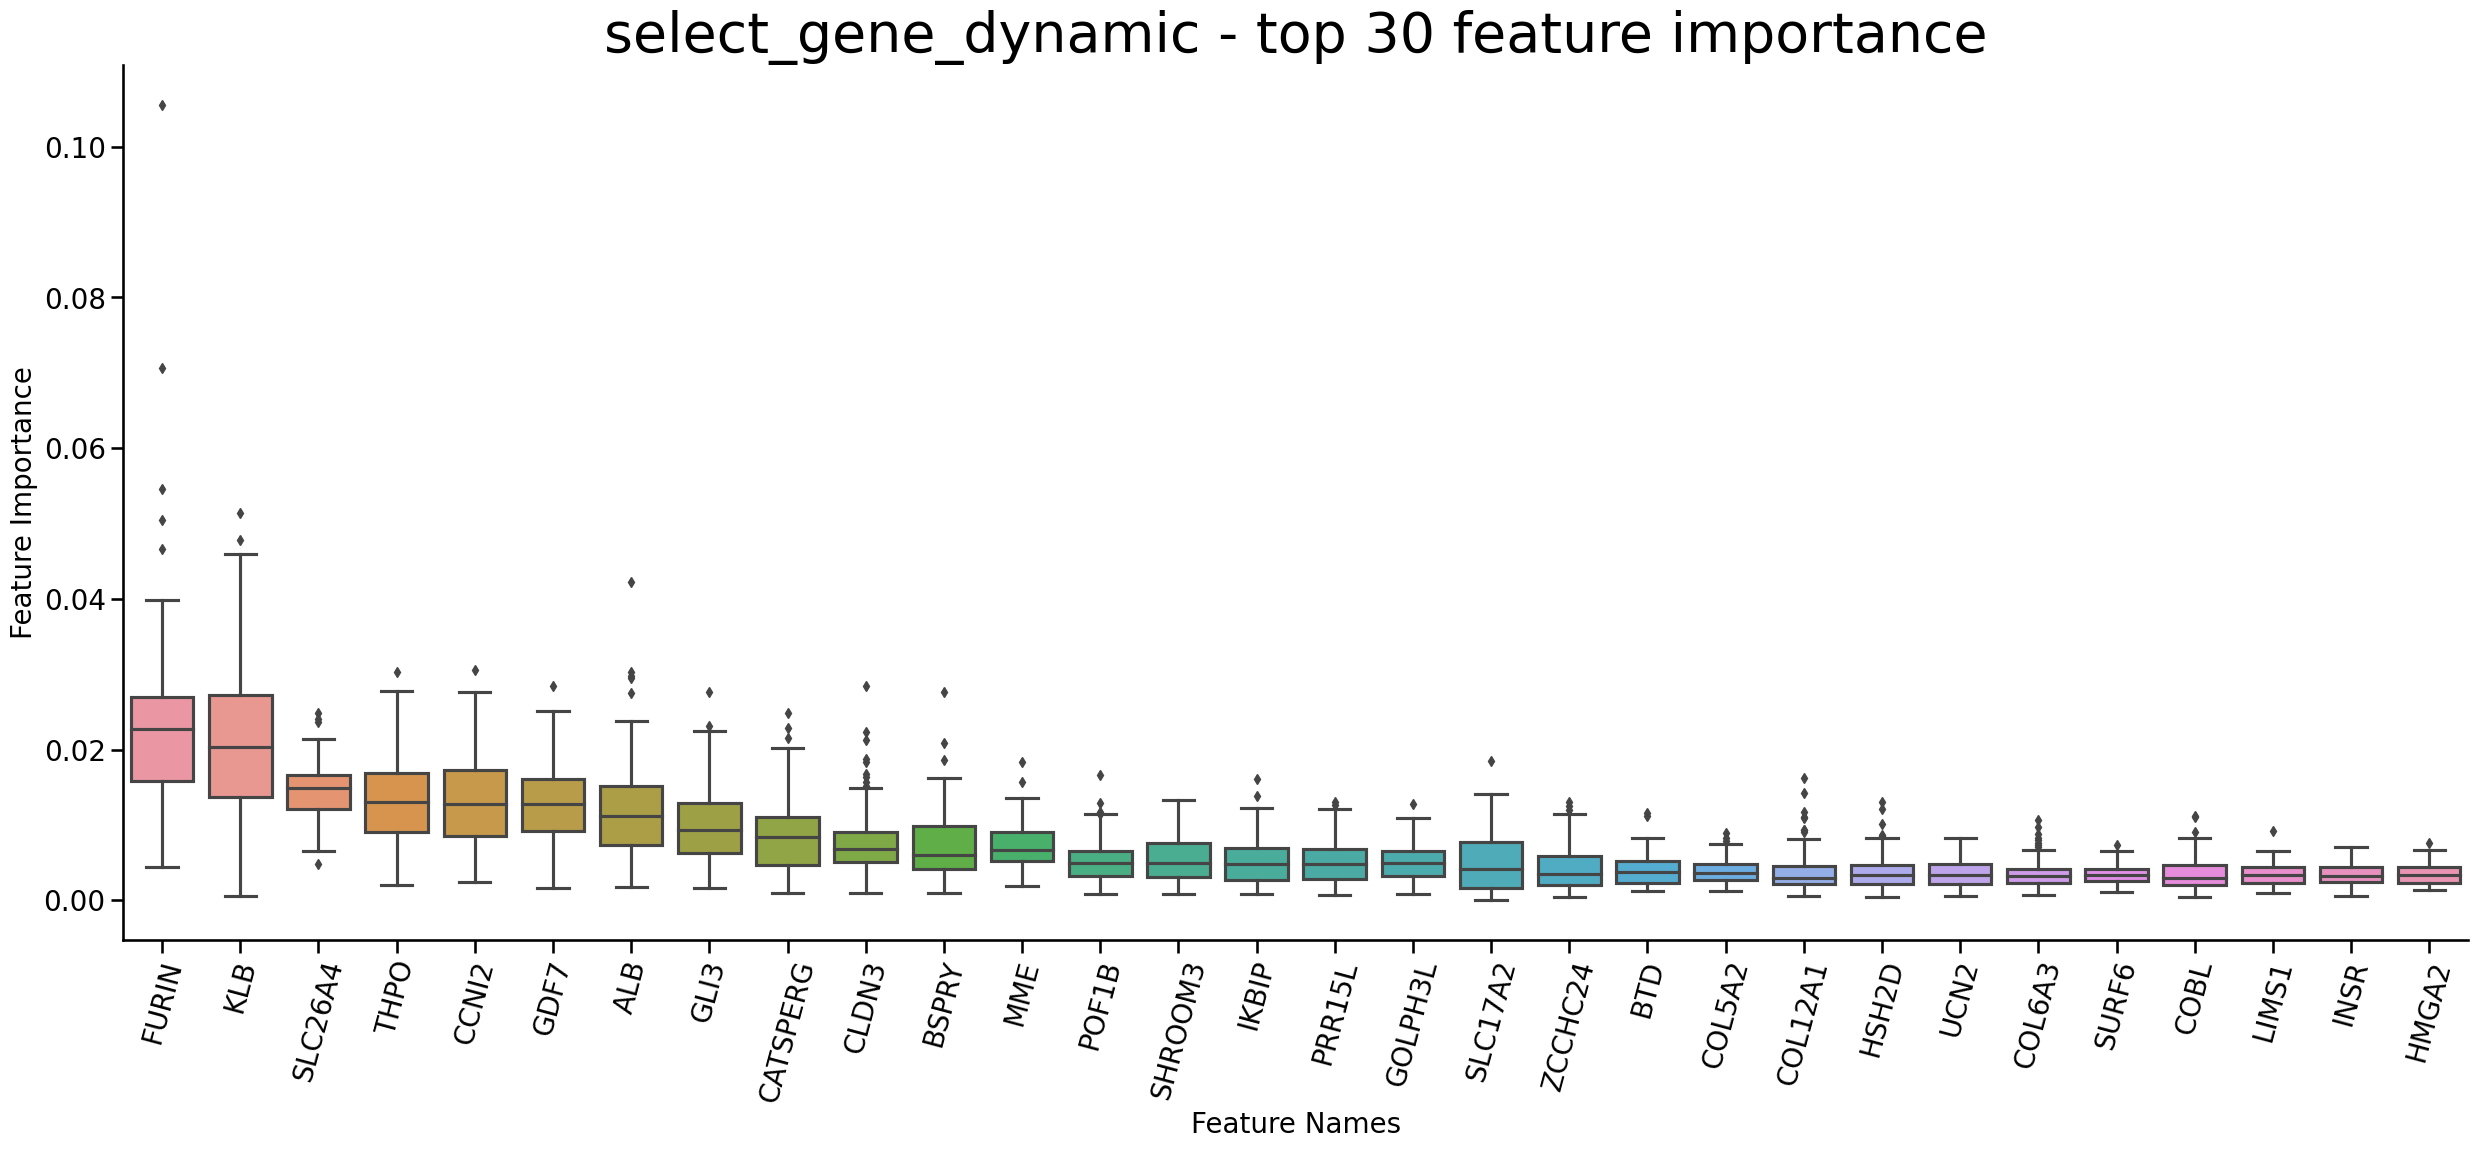

In [52]:
features_to_include = mean_df.index[:30]

# filter the dataframe by the features to include
filtered_df = df[df['feature_names'].isin(features_to_include)]

plot_order = filtered_df.groupby('feature_names').mean().sort_values('scores', ascending=False).index

sns.set_context('talk')

# plot the boxplot
sns.catplot(x='feature_names', y='scores', data=filtered_df, kind='box', height=10, aspect=2.5, order=plot_order)

# enlarge the x axis labels and y axis labels
plt.xlabel('Feature Names', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title(f'{exp_condition} - top 30 feature importance', fontsize=40)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)
plt.show()